# Estimating the Date of COVID-19 Changes

https://nbviewer.jupyter.org/github/jramkiss/jramkiss.github.io/blob/master/_posts/notebooks/covid19-changes.ipynb 

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


from sklearn.linear_model import LinearRegression

from scipy import stats
import statsmodels.api as sm
import pylab

# from google.colab import files
# from io import StringIO
# uploaded = files.upload()

url = 'https://raw.githubusercontent.com/assemzh/ProbProg-COVID-19/master/israel.csv'
data = pd.read_csv(url)

data.Date = pd.to_datetime(data.Date)

# for fancy python printing
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 250

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

data.tail()

,Date,Country/Region,Province_State,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered
396,2021-04-22,Israel,NaN,837807.0,6346.0,829424.0,2037.0,85.0,0.0,272.0
397,2021-04-23,Israel,NaN,837892.0,6346.0,829696.0,1850.0,82.0,4.0,115.0
398,2021-04-24,Israel,NaN,837974.0,6350.0,829811.0,1813.0,50.0,2.0,172.0
399,2021-04-25,Israel,NaN,838024.0,6352.0,829983.0,1689.0,83.0,1.0,105.0
400,2021-04-26,Israel,NaN,838107.0,6353.0,830088.0,1666.0,NaN,NaN,NaN


## Create country


In [ ]:
# function to make the time series of confirmed and daily confirmed cases for a specific country
def create_country (country, end_date, state = False) : 
    if state :
        df = data.loc[data["Province/State"] == country, ["Province/State", "Date", "Confirmed", "Deaths", "Recovered"]]
    else : 
        df = data.loc[data["Country/Region"] == country, ["Country/Region", "Date", "Confirmed", "Deaths", "Recovered"]]
    df.columns = ["country", "date", "confirmed", "deaths", "recovered"]

    # group by country and date, sum(confirmed, deaths, recovered). do this because countries have multiple cities 
    df = df.groupby(['country','date'])['confirmed', 'deaths', 'recovered'].sum().reset_index()

    # convert date string to datetime
    df.date = pd.to_datetime(df.date)
    df = df.sort_values(by = "date")
    df = df[df.date <= end_date]


    # make new confirmed cases every day:
    cases_shifted = np.array([0] + list(df.confirmed[:-1]))
    daily_confirmed = np.array(df.confirmed) - cases_shifted
    df["daily_confirmed"] = daily_confirmed 

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    ax = [ax]
    sns.lineplot(x = df.date, 
                 y = df.daily_confirmed, 
                 ax = ax[0])

    ax[0].set(ylabel='Daily Confirmed Cases')

    ax[0].axvline(pd.to_datetime('2020-12-20'), 
              linestyle = '--', linewidth = 1.5,
              label = "Vaccination start: Dec 20, 2020" ,
              color = "red") 
    
    ax[0].xaxis.get_label().set_fontsize(22)
    ax[0].yaxis.get_label().set_fontsize(22)
    x = df.date
    ax[0].set_xticks(x[::170])
    # ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=5))   #to get a tick every month

    ax[0].title.set_fontsize(20)
    ax[0].tick_params(labelsize=22)
    myFmt = mdates.DateFormatter('%b %-d, %Y')
    ax[0].xaxis.set_major_formatter(myFmt)
    ylabels = ['{}'.format(round(x)) for x in ax[0].get_yticks()/1000]
    ax[0].set_yticklabels(ylabels)

    ax[0].set(ylabel='', xlabel='');
    ax[0].legend(loc = "bottom right", fontsize=22)

    sns.set_style("ticks")
    plt.tight_layout()
    sns.despine()
    plt.savefig('/content/sample_data/israel_daily.pdf')
    print(df.tail())
    return df


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

    country       date  confirmed  deaths  recovered  daily_confirmed
396  Israel 2021-04-22   837807.0  6346.0   829424.0            315.0
397  Israel 2021-04-23   837892.0  6346.0   829696.0             85.0
398  Israel 2021-04-24   837974.0  6350.0   829811.0             82.0
399  Israel 2021-04-25   838024.0  6352.0   829983.0             50.0
400  Israel 2021-04-26   838107.0  6353.0   830088.0             83.0


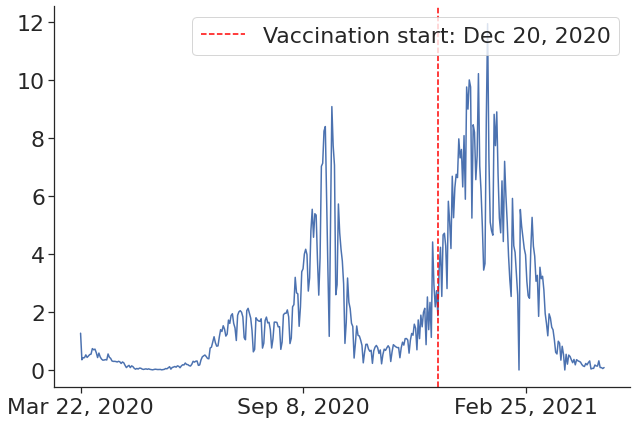

In [ ]:
cad = create_country("Israel", end_date = "2021-04-26")

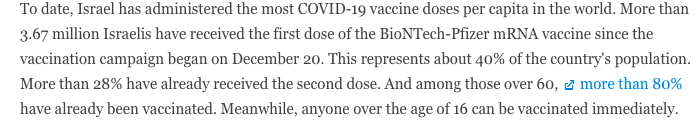

https://www.dw.com/en/israels-clever-coronavirus-vaccination-strategy/a-56586888#:~:text=To%20date%2C%20Israel%20has%20administered,40%25%20of%20the%20country's%20population.

In [ ]:
cad_start = "2020-12-01" # 13 confirmed cases
cad = cad[cad.date >= cad_start].reset_index(drop = True)
cad["days_since_start"] = np.arange(cad.shape[0]) + 1

## Data for Regression

In [ ]:
# variable for data to easily swap it out:
country_ = "Israel"
reg_data = cad.copy()

In [ ]:
reg_data.head()

,country,date,confirmed,deaths,recovered,daily_confirmed,days_since_start
0,Israel,2020-12-01,338389.0,2882.0,324396.0,1198.0,1
1,Israel,2020-12-02,339968.0,2886.0,325255.0,1579.0,2
2,Israel,2020-12-03,341406.0,2895.0,326706.0,1438.0,3
3,Israel,2020-12-04,342101.0,2896.0,327162.0,695.0,4
4,Israel,2020-12-05,343826.0,2909.0,327749.0,1725.0,5


In [ ]:
reg_data.shape

(147, 7)

## Change Point Estimation in Pyro

In [ ]:
!pip install pyro-ppl
!pip install numpyro

In [ ]:
import torch

import pyro
import pyro.distributions as dist
from torch import nn
from pyro.nn import PyroModule, PyroSample

from pyro.infer import MCMC, NUTS, HMC
from pyro.infer.autoguide import AutoGuide, AutoDiagonalNormal

from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive

# First method

In [ ]:
# we should be able to have an empirical estimate for the mean of the prior for the 2nd regression bias term
# this will be something like b = log(max(daily_confirmed))

# might be able to have 1 regression model but change the data so that we have new terms for (tau < t) 
# like an interaction term

class COVID_change(PyroModule):
    def __init__(self, in_features, out_features, b1_mu, b2_mu):
        super().__init__()
        self.linear1 = PyroModule[nn.Linear](in_features, out_features, bias = False)
        self.linear1.weight = PyroSample(dist.Normal(0.5, 0.25).expand([1, 1]).to_event(1))
        self.linear1.bias = PyroSample(dist.Normal(b1_mu, 1.))
        
        # could possibly have stronger priors for the 2nd regression line, because we wont have as much data
        self.linear2 = PyroModule[nn.Linear](in_features, out_features, bias = False)
        self.linear2.weight = PyroSample(dist.Normal(0., 0.25).expand([1, 1])) #.to_event(1))
        self.linear2.bias = PyroSample(dist.Normal(b2_mu, b2_mu/4))

    def forward(self, x, y=None):
        tau = pyro.sample("tau", dist.Beta(4, 3))
        sigma = pyro.sample("sigma", dist.Uniform(0., 3.))
        # fit lm's to data based on tau
        sep = int(np.ceil(tau.detach().numpy() * len(x)))
        mean1 = self.linear1(x[:sep]).squeeze(-1)
        mean2 = self.linear2(x[sep:]).squeeze(-1)
        mean = torch.cat((mean1, mean2))
        obs = pyro.sample("obs", dist.StudentT(2, mean, sigma), obs=y)
        return mean

In [ ]:
tensor_data = torch.tensor(reg_data[["confirmed", "days_since_start", "daily_confirmed"]].values, dtype=torch.float)
x_data = tensor_data[:, 1].unsqueeze_(1)
y_data = np.log(tensor_data[:, 0])
y_data_daily = np.log(tensor_data[:, 2])
# prior hyper params
# take log of the average of the 1st quartile to get the prior mean for the bias of the 2nd regression line
q1 = np.quantile(y_data, q = 0.25)
bias_1_mean = np.mean(y_data.numpy()[y_data <= q1])
print("Prior mean for Bias 1: ", bias_1_mean)

# take log of the average of the 4th quartile to get the prior mean for the bias of the 2nd regression line
q4 = np.quantile(y_data, q = 0.75)
bias_2_mean = np.mean(y_data.numpy()[y_data >= q4])
print("Prior mean for Bias 2: ", bias_2_mean)

Prior mean for Bias 1:  12.849834
Prior mean for Bias 2:  13.6347475


In [ ]:
model = COVID_change(1, 1, 
                     b1_mu = bias_1_mean,
                     b2_mu = bias_2_mean)
# need more than 400 samples/chain if we want to use a flat prior on b_2 and w_2
num_samples = 400 
# mcmc 
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, 
            num_samples=num_samples,
            warmup_steps = 200, 
            num_chains = 1)
mcmc.run(x_data, y_data)

Sample: 100%|██████████| 600/600 [19:50,  1.98s/it, step size=9.91e-04, acc. prob=0.666]


In [ ]:
# Save the model:
import dill
# with open('israel_new.pkl', 'wb') as f:
# 	dill.dump(mcmc, f)
with open('israel_new.pkl', 'rb') as f:
	mcmc = dill.load(f)
 
samples = mcmc.get_samples()

In [ ]:
# extract individual posteriors
weight_1_post = samples["linear1.weight"].detach().numpy()
weight_2_post = samples["linear2.weight"].detach().numpy()
bias_1_post = samples["linear1.bias"].detach().numpy()
bias_2_post = samples["linear2.bias"].detach().numpy()
tau_post = samples["tau"].detach().numpy()
sigma_post = samples["sigma"].detach().numpy()

# build likelihood distribution:
tau_days = list(map(int, np.ceil(tau_post * len(x_data))))
mean_ = torch.zeros(len(tau_days), len(x_data))
obs_ = torch.zeros(len(tau_days), len(x_data))
for i in range(len(tau_days)) : 
    mean_[i, :] = torch.cat((x_data[:tau_days[i]] * weight_1_post[i] + bias_1_post[i],
                          x_data[tau_days[i]:] * weight_2_post[i] + bias_2_post[i])).reshape(len(x_data))
    obs_[i, :] = dist.Normal(mean_[i, :], sigma_post[i]).sample()
samples["_RETURN"] = mean_
samples["obs"] = obs_
pred_summary = summary(samples)
mu = pred_summary["_RETURN"] # mean
y = pred_summary["obs"] # samples from likelihood: mu + sigma
y_shift = np.exp(y["mean"]) - np.exp(torch.cat((y["mean"][0:1], y["mean"][:-1])))
print(y_shift)
predictions = pd.DataFrame({
    "days_since_start": x_data[:, 0],
    "mu_mean": mu["mean"],    # mean of likelihood
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],      # mean of likelihood + noise
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_confirmed": y_data,
    "true_daily_confirmed": y_data_daily,
    "y_daily_mean": y_shift
})

w1_ = pred_summary["linear1.weight"]
w2_ = pred_summary["linear2.weight"]

b1_ = pred_summary["linear1.bias"]
b2_ = pred_summary["linear2.bias"]

tau_ = pred_summary["tau"]
sigma_ = pred_summary["sigma"]

ind = int(np.ceil(tau_["mean"] * len(x_data)))

tensor([    0.0000,  3897.4062,  3952.1562,  4050.7188,  3615.7812,  3728.2812,
         4274.7188,  3263.0000,  4358.2188,  3862.7188,  5077.4062,  3452.1562,
         4076.4688,  4237.3125,  5129.4062,  3726.9062,  4248.5312,  5507.0625,
         3093.2188,  5924.8125,  3792.3750,  4752.2500,  5327.9062,  3826.3750,
         5517.8750,  5089.8438,  5393.5938,  3654.0625,  6585.0938,  4046.8125,
         6048.1875,  5093.4688,  5010.3750,  5921.5938,  5961.1562,  5405.5000,
         5872.9375,  4662.8125,  5232.2188,  6545.6875,  6311.2812,  6468.8125,
         5882.4375,  6132.3438,  6062.4062,  5963.0938,  5833.5000,  7093.5625,
         5992.8125,  6615.5625,  6426.8125,  7143.6250,  6419.0000,  7113.8125,
         6659.2500,  6437.5000,  7942.4375,  7400.3125,  7771.3750,  6535.2500,
         8666.5625,  7089.3125,  7544.8750,  7469.2500,  9253.7500,  7147.1875,
         8828.0625,  7230.2500,  8460.3750,  8569.5625,  8478.3125,  6977.1875,
        10170.6250,  8898.0000,  8932.18

In [ ]:
mcmc.summary()
diag = mcmc.diagnostics()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
                tau      0.53      0.01      0.53      0.51      0.55     98.34      1.00
              sigma      0.02      0.00      0.02      0.02      0.02     26.54      1.04
linear1.weight[0,0]      0.01      0.00      0.01      0.01      0.01     41.28      1.00
       linear1.bias     12.62      0.01     12.62     12.60     12.64     38.73      1.01
linear2.weight[0,0]      0.00      0.00      0.00      0.00      0.00    217.67      1.00
       linear2.bias     13.45      0.02     13.45     13.41     13.49    196.52      1.00

Number of divergences: 0


78
2021-02-17 00:00:00


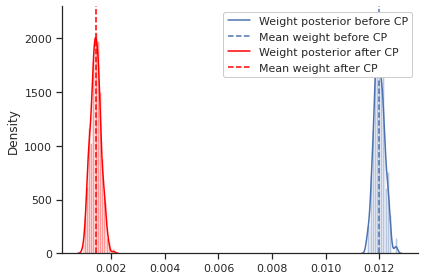

In [ ]:
print(ind)
print(reg_data.date[ind])

sns.distplot(weight_1_post, 
             kde_kws = {"label": "Weight posterior before CP"}, 
            #  color = "red",
             norm_hist = True,
             kde = True)
plt.axvline(x = w1_["mean"], linestyle = '--',label = "Mean weight before CP" ,
              # color = "red"
              )

sns.distplot(weight_2_post, 
             kde_kws = {"label": "Weight posterior after CP"}, 
             color = "red",
             norm_hist = True,
             kde = True)
plt.axvline(x = w2_["mean"], linestyle = '--',label = "Mean weight after CP" ,
              color = "red")

legend = plt.legend(loc='upper right')
legend.get_frame().set_alpha(1)
sns.set_style("ticks")
plt.tight_layout()
sns.despine()
plt.savefig('/content/sample_data/israel_weights.pdf')


In [ ]:
print(w1_["mean"])
print(w2_["mean"])

tensor([[0.0120]])
tensor([[0.0014]])


In [ ]:
1 - 14/120

0.8833333333333333

Date of change for Israel: 2021-02-17
Index(['country', 'date', 'confirmed', 'deaths', 'recovered',
       'daily_confirmed', 'days_since_start'],
      dtype='object')


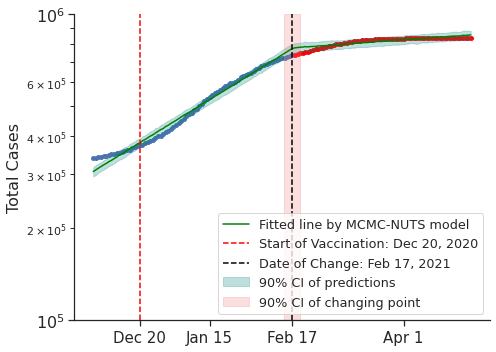

In [ ]:
start_date_ = str(reg_data.date[0]).split(' ')[0]
change_date_ = str(reg_data.date[ind]).split(' ')[0]
print("Date of change for {}: {}".format(country_, change_date_))
import seaborn as sns

# plot data:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
ax = [ax]
# log regression model
ax[0].scatter(y = np.exp(y_data[:ind]), x = x_data[:ind], s = 15);
ax[0].scatter(y = np.exp(y_data[ind:]), x = x_data[ind:], s = 15, color = "red");

ax[0].plot(predictions["days_since_start"],
           np.exp(predictions["y_mean"]), 
           color = "green",
           label = "Fitted line by MCMC-NUTS model") 
ax[0].axvline(19, 
              linestyle = '--', linewidth = 1.5,
              label = "Start of Vaccination: Dec 20, 2020" ,
              color = "red")

ax[0].axvline(ind, 
              linestyle = '--', linewidth = 1.5,
              label = "Date of Change: Feb 17, 2021",
              color = "black")

ax[0].fill_between(predictions["days_since_start"], 
                   np.exp(predictions["y_perc_5"]), 
                   np.exp(predictions["y_perc_95"]), 
                   alpha = 0.25,
                   label = "90% CI of predictions",
                   color = "teal");
ax[0].fill_betweenx([0, 1], 
                    tau_["5%"] * len(x_data), 
                    tau_["95%"] * len(x_data), 
                    alpha = 0.25,
                    label = "90% CI of changing point",
                    color = "lightcoral",
                    transform=ax[0].get_xaxis_transform());
ax[0].set(ylabel = "Total Cases",)
          # xlabel = "Days since %s" % start_date_, 
          # title = "Confirmed Cases in China") /
ax[0].legend(loc = "lower right", fontsize=12.8)
ax[0].set_ylim([100000,1000000])
ax[0].xaxis.get_label().set_fontsize(16)
ax[0].yaxis.get_label().set_fontsize(16)
ax[0].title.set_fontsize(20)
ax[0].tick_params(labelsize=16)

plt.xticks(ticks=[19,46,78,121], labels=["Dec 20",
                                             "Jan 15",
                                             "Feb 17",
                                             "Apr 1"], fontsize=15)
ax[0].set_yscale('log')
plt.setp(ax[0].get_xticklabels(), rotation=0, horizontalalignment='center')
print(reg_data.columns)
myFmt = mdates.DateFormatter('%m-%d')
sns.set_style("ticks")
sns.despine()
plt.tight_layout()
ax[0].figure.savefig('/content/sample_data/israel_cp.pdf')
